# Challenge: What is the future selling price of a home?

<br>
<br>

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important.

In this competition, students are required to develop a full-fledged approach to make predictions about the future sale prices of homes. A full-fledged approach constist, at least, in the following steps:

* Descriptive statistics about the data
* Data cleaning and pre-processing
* Defining a modeling approach to the problem
* Build such a statistical model
* Validate the outcome of the model

Now, should you ask a home buyer to describe their dream house, they probably wouldn't begin with describing features such as the height of the basement ceiling or the proximity to a railroad. As you will see, the dataset we use in this competition proves that many more features influence price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in a small city in the US, this competition challenges you to predict the final price of each home.

## Imports

We need to import Python libraries such as pandas, numpy or matplotlib, etc...

In [107]:
import os
import sys
import re
import random
import math
import scipy
import pylab as pl
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.patches as pat
import matplotlib.gridspec as gridspec
import matplotlib.colors as clr
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import IsolationForest
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm




from datetime import datetime
from datetime import timedelta
from itertools import islice
#import statsmodels.api as sm

from IPython.display import HTML
#Map widget
#install = !pip install ipyleaflet
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON, DrawControl, LayerGroup, basemaps
)
#install = !pip install geocoder
#install = !apt-get install ImageMagick
import geocoder

# !apt-get install ImageMagick #Package to convert images to gif

## A. Retrieve the data and compare to the description text

In order to analyse it, we need to retrieve the data which is in a csv file.

In [3]:
challenge_data_folder = "./challenge_data"

pdAllData_Categ = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False)
pdTestData_Categ = pd.read_csv(challenge_data_folder+"/test.csv",keep_default_na=False)
#Load training data keep_default_na FALSE to keep "Not available" data as they transport information

columnTypesDict = pdAllData_Categ.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name

In [4]:
pdAllData_Categ.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


We have now correctly imported the data that is now saved in a pandas dataframe structure.
<br>
We also have the list of the columns' names and their type.

At a first, the only information we have on the data set resides in the description file therefore we tried to match the data and the description file to make sure the data is clean and clear. One must first match features names and then specified values in the description file and in the dataset.

In [5]:
def checkWithDescription(description_file_Path):
    
    """Checks in the data for not mentioned values in the description file given."""
    
    #Importation of the text description
    pathDescr = (challenge_data_folder+description_file_Path)
    txtDescripData = open(pathDescr).readlines()
    
    columnIndex=[]
    nbHeader = 7
    NoHeaderTxtDescripData = txtDescripData[nbHeader:]
    #Parse the description file to retrieve all the lines that corresponds to features    
    for feature in columnNames:
        if feature == 'Id': continue
        for index,line in enumerate(NoHeaderTxtDescripData):
            if feature in line: #Match features name and stated name in the description
                if(line.split(feature)[0]=='' and line.split(feature)[1][0]==':' ): #Make sure exactly this feature in this line 
                    columnIndex.append((feature,index)) #We retrieved the line where the feature is described
                pass

    NoSpecificValfeatures = []
    SpecificVal = {} #Will contain as keys column names and values the specified values in the description file
    
    #Scan the document to retrieve specfic values for each featurz
    for index,featureLine in enumerate(columnIndex):

        startLine= featureLine[1]+2  #RTF file format 
        if index == len(columnIndex)-1: endLine = len(NoHeaderTxtDescripData)-1
        else: endLine = columnIndex[index+1][1]-1
        values = []
        if endLine <= startLine: #No specified value in the description file
            NoSpecificValfeatures.append(featureLine[0])
            continue
        for i in range(startLine,endLine):
            line = NoHeaderTxtDescripData[i] 
            values.append(line.split('\t')[0].strip())
        SpecificVal[featureLine[0]]=values #All values specified are retrieved and kept in this dictionary
        
    #Retrieve Bad values for the columns with specified values
    dicBadValues = []
    for factor in SpecificVal:

        #For a factor search for any value not specified in the description file 
        #In terms of type of valu

        typeCol = columnTypesDict[factor]
        if typeCol == 'int64': valSpec = [int(i) for i in SpecificVal[factor]]
        else: valSpec = SpecificVal[factor]
        pdInter = pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1)
        potentialBadValues = pdAllData_Categ[pdAllData_Categ.apply(lambda x: x[factor] not in valSpec,axis=1)]
        nbBadVal = len(potentialBadValues)

        if nbBadVal>0:
            badValues = [factor]
            badValues.append(potentialBadValues.groupby(factor)[factor].count().to_dict())
            dicBadValues.append(badValues)
    #Retrieve Bad values for the columns with not specified values such as year of construction of 

    for feature in NoSpecificValfeatures:
        dtypeColumn = columnTypesDict[feature]
        if dtypeColumn=='float64': typeFun = float #infered type -> check if any values do not convert to this type
        elif dtypeColumn=='int64': typeFun = int
        else: typeFun=lambda x: True
        pdInter = pdAllData_Categ[pdAllData_Categ.apply(lambda x: (x[feature]=='NA') and typeFun(x[feature]) ,axis=1)]
        if len(pdInter)>0:
            badValues=[feature]
            badValues.append(pdInter.groupby(feature)[feature].count().to_dict())
            dicBadValues.append(badValues)
            
    return SpecificVal, NoSpecificValfeatures, dicBadValues

In [6]:
bad_description_file_Path = "/Bad_Description.rtf"
bad_specificVal, bad_noSpecificValfeatures, bad_dicBadValues = checkWithDescription(bad_description_file_Path)
bad_dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['Neighborhood', {'NAmes': 179}],
 ['BldgType', {'2fmCon': 28, 'Duplex': 41, 'Twnhs': 37}],
 ['Exterior2nd', {'Brk Cmn': 7, 'CmentBd': 49, 'Wd Shng': 29}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

First of all, some column names were wrong in the description file erors. By deducing form the data, we changed Bedroom to BedroomAbvGr and Kitchen to KitchenAbvGr.
<br>
There are also errors in the values described.
<br>
In the result above, the number corresponds the how many times the key appears in the column. All the values that appear here are not consistent with the text description.
<br>
Most errors with the initial description are easily corrected by slighlty modifying the description file, but some are more complex and persist such as :<br>
<li>C(all): is it a commercial one or a sort of "we don't know", or another information?
<li>Twnhs: is it a townhouse end unit or a townhouse inside unit, or another townhouse not present in the text description? We don't know.
<br><br>
They have no direct typo or writings and the other values specified are included in the data.<br>
Although those values are not explicit in the description file, they contain information so we decided to keep them eventhough no direct explanation of those categories is available.

In [7]:
description_file_Path = "/Data description.rtf"
SpecificVal, NoSpecificValfeatures, dicBadValues = checkWithDescription(description_file_Path)
dicBadValues

[['MSZoning', {'C (all)': 9}],
 ['BldgType', {'Twnhs': 37}],
 ['MasVnrType', {'NA': 6}],
 ['LotFrontage', {'NA': 210}],
 ['MasVnrArea', {'NA': 6}],
 ['GarageYrBlt', {'NA': 67}]]

Now we have corrected some typos in the text description.
<br>
Otherwise, the other NA values can contain information that means the information is not available'.
<br>
By doing some statistics about the data (especially for the features MSZoning, BldgType, MasVnrType and MasVnrArea, LotFrontage and GarageYrBlt), we'll try to find a way to reduce the impact of these invalid values while keeping the rest of the information.

## B. Data statistics

We need to understand the data we are working with.

### 1. Sale Price: the value to predict

To begin, we can try to understand the distribution of the saling price which is the value we'll try to guess according to the data we have.

Number of unvalid sample with a sale price <= 0: 0


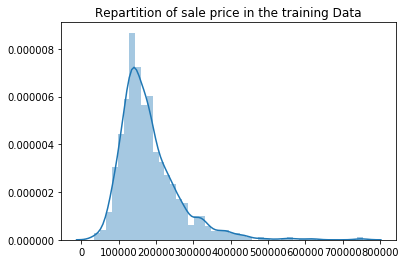

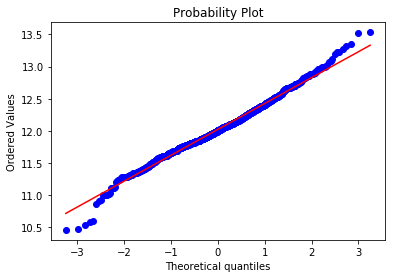

In [8]:
salePrices = pdAllData_Categ.SalePrice.tolist()

print("Number of unvalid sample with a sale price <= 0:",pdAllData_Categ.SalePrice[pdAllData_Categ.SalePrice<=0].count())

#plt.boxplot(salePrices, vert=False)
sns.distplot(salePrices)
plt.title("Repartition of sale price in the training Data")

plt.show()

probabilityPlot = scipy.stats.probplot(np.log(salePrices), plot=plt)

We note that the distribution seems to be lognormal. If it is, the log of the saling prices must be normal. In order to verify that, we can use a probability plot. The more the points are inline, the more it is close to a normal distribution, and the more the saling prices are a lognormal distribution.
<br>
We can see that the curve is really close to be a line (except for some points at the beginning and at the end), that means the saling price can be approched by a lognormal distribution.

### 2. Ground Living Area VS Sale Price: a good indicator?

When we buy a house, things that seem to be important for us to determine the price is the living area. We'll see how much this component is important to the price.

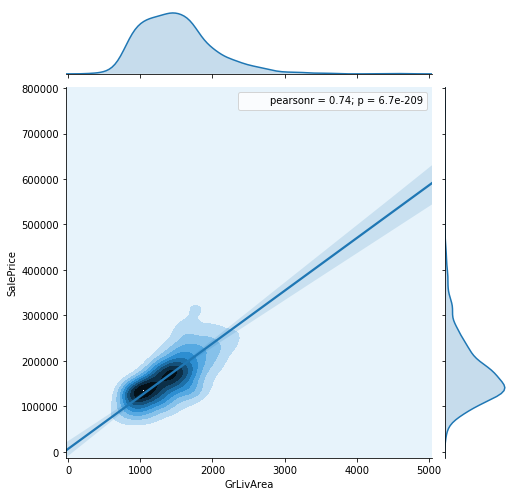

In [9]:
g = sns.jointplot("GrLivArea", "SalePrice", data=pdAllData_Categ, kind="kde", size=7)
sns.regplot("GrLivArea", "SalePrice", data=pdAllData_Categ, scatter=False, ax=g.ax_joint)
plt.show()

With this plot, we see the distribution of the Sale Price according to the Ground Living Area.
<br>
The two features seem to be correlated, the pearson correlation coefficient is 0.74. But the Ground Living Area seem to not be sufficient to guess the price because we see that the error can be large. Other factors have to be taken into account.

### 3. Neighborhood: the price depends on it?

When we want to buy a house, we know that the price for quite similar houses can be very different according to where it is. We'll study the influence of the neighborhood on the price.

In [10]:
txtDescripData = open(challenge_data_folder+"/Data description.rtf").readlines()
dicStreetName = {} # Abbreviation : Street name
dicStreetLoc = {} # Abbreviation : location returned by geocoder
for index in range(92,117):
    line = txtDescripData[index]
    line = line.strip()
    line = line.split('\t')
    dicStreetName[line[0]]= line[1][:-1]
    dicStreetLoc[line[0]] = geocoder.google(line[1][:-1]+', Ames')

In [11]:
def calcAreasPrices(pdDF):
    """
    Returns dictionnaire = {"Neigborhood":areaPrice}
    
    """
    dicStreetPriceAreas={}
    
    def calcAreaPrice(row):
        neighborhood = row.Neighborhood
        try:
            dicStreetPriceAreas[neighborhood] #see if already defined
        except KeyError:
            dicStreetPriceAreas[neighborhood]=[0,0,0]
        dicStreetPriceAreas[neighborhood][0]+=row.SalePrice
        dicStreetPriceAreas[neighborhood][1]+=row.LotArea
        
    none = pdDF.apply(calcAreaPrice,axis=1) #fill the dictionnary
    
    for place in dicStreetPriceAreas:
        areaPrice = dicStreetPriceAreas[place][0]/dicStreetPriceAreas[place][1]
        dicStreetPriceAreas[place] = areaPrice
        
    return dicStreetPriceAreas
    
dicStreetPriceAreas = calcAreasPrices(pdAllData_Categ)
print(dicStreetPriceAreas)

{'CollgCr': 20.43893739265472, 'Veenker': 15.133918143832238, 'Crawfor': 16.92658934743337, 'NoRidge': 23.049928679388874, 'Mitchel': 14.23237526116939, 'Somerst': 29.55322320949371, 'NWAmes': 16.49992834611817, 'OldTown': 15.708946967813892, 'BrkSide': 16.910100475938656, 'Sawyer': 13.4242253219904, 'NridgHt': 28.8899788413152, 'NAmes': 14.189682044633944, 'SawyerW': 19.38387882154937, 'IDOTRR': 12.054208428802571, 'MeadowV': 41.25743415463042, 'Edwards': 12.843999136512851, 'Timber': 9.50119128123673, 'Gilbert': 17.19430711971769, 'StoneBr': 29.490541930638102, 'ClearCr': 6.732846177897465, 'NPkVill': 49.569387355646896, 'Blmngtn': 57.70382718760606, 'BrDale': 59.280813815945116, 'SWISU': 17.504403242359622, 'Blueste': 84.61538461538461}


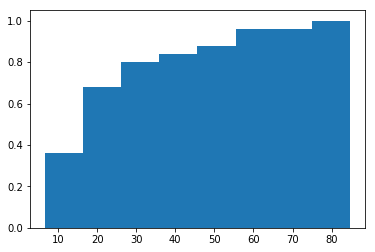

In [12]:
areaPrices = calcAreasPrices(pdAllData_Categ).values()
hist = plt.hist(areaPrices, cumulative=True, normed=True, bins='auto')
plt.title('')
plt.show()

In [13]:
#Define the colors variable that give a color thanks to the cumulative histogram to better see the different in SalePrice

hist = plt.hist(pdAllData_Categ.SalePrice,cumulative=True,normed=True,bins='auto')

def salePriceColor(hist,salePrice):
    index = [i for i,x in enumerate(hist[1]) if x<=salePrice][-1]
    return hist[0][max(0,index-1)]

def normHist(row):
    salePrice = row.SalePrice
    return salePriceColor(hist,salePrice)

colors = pdAllData_Categ.apply(normHist,axis=1) #Color the points in function of the sale price with a gradient guided by the cumulated histogramm

plt.clf()
plt.close()

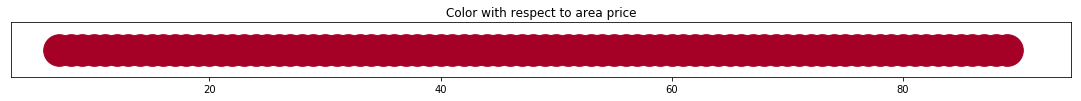

Area Price around Ames


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[42.0307812, -93.63191309999999], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), LayerGroup(layers=(CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0214236, -93.64965409999999], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0413042, -93.6503018], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0262539, -93.6204523], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0478088, -93.6487377], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[41.9903084, -93.60105329999999], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.05262800000001, -93.644582], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0018366, -93.6349291], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[None, None], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.02894990000001, -93.6297476], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0339027, -93.6770658], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0478046, -93.6466753], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0307812, -93.63191309999999], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0339027, -93.6770658], options=['class_name', 'clickable', 'color', 'dash_array', 'fill', 'fill_color', 'fill_opacity', 'line_cap', 'line_join', 'opacity', 'pointer_events', 'radius', 'stroke', 'weight']), CircleMarker(color='#a50026', fill_color='#a50026', location=[42.0219974,

In [18]:
markersList = []
for place in dicStreetPriceAreas:
    coordGeo = dicStreetLoc[place]
    areaPrice = dicStreetPriceAreas[place]
    try:
        lastLowerValuesIndex = list(map(lambda x: x <= areaPrice,hist[1])).index(False)-1
    except ValueError:
        lastLowerValuesIndex = len(hist[0])-1
    #print(lastLowerValuesIndex)
    colorfloat = hist[0][lastLowerValuesIndex] #Use the cumulative hist to get the color
    #colorfloat = (-minAreaPrice)/(maxAreaPrice-minAreaPrice)

    #print(dicStreetPirceArea[place][2],colorfloat)
    markerColor = clr.rgb2hex(cmapRdYlGn(1-colorfloat))#green to red
    marker = CircleMarker(location=(coordGeo.lat, coordGeo.lng), radius=10, color=markerColor, fill_color=markerColor)
    markersList.append(marker)

g = geocoder.google('Ames')
m = Map(center=[g.lat, g.lng], zoom=12)

markersList = [x for x in markersList if x!=None]
group = LayerGroup(layers=markersList)

#PLot color bar
fig,ax = fig, ax = plt.subplots(figsize=(19,1))
plt.title("Color with respect to area price")
minPriceArea,maxPriceArea = 7,90
for areaPrice in np.arange(minPriceArea,maxPriceArea,1):
    try:
        lastLowerValuesIndex = list(map(lambda x: x<= areaPrice,hist[1])).index(False)-1
    except ValueError:
        lastLowerValuesIndex = len(hist[0])-1
    #print(lastLowerValuesIndex)
    colorfloat = hist[0][lastLowerValuesIndex] #Use the cumulative hist to get the color
    plt.scatter(areaPrice,0,c = cmapRdYlGn(1-colorfloat),s=1000)
plt.setp( ax.get_yticklabels(), visible=False)
ax.yaxis.set_ticks_position('none') 
plt.show()

m.add_layer(group)
print("Area Price around Ames")
m

COMMENT ON THE MAP.

### 4. MSZoning: general zoning of the sale

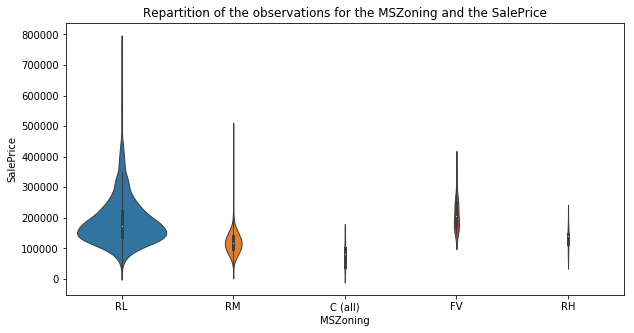

In [19]:
plt.figure(figsize=(10,5))
sns.violinplot("MSZoning", "SalePrice", data=pdAllData_Categ, linewidth=1, scale='count')
plt.title('Repartition of the observations for the MSZoning and the SalePrice')
plt.show()

Here we don't have all the expected categories. We note that the C category is missing, where we have a 'C (all)'. It can maybe replace the C category but we don't know. In the next steps, we'll process the categorized features to have numbers instead, so it's not really important to have a C (all) instead of a C. That's why we decided to not change this value.
<br>
We also see that the RL category has the larger count of observations.

### 5. Conditions: A first and a second condition

We have 2 features for the proximity to conditions and the list of possible conditions is the same.
<br>
We'll first verify that we don't have the same condition twice. Another thing to verify is that when the second condition is not Norm, the first mustn't be Norm.

In [20]:
pd.DataFrame(pdAllData_Categ.groupby(['Condition1', 'Condition2']).size(), columns=['count'])

count
Condition1 Condition2       
Artery     Artery          2
           Norm           38
           PosA            1
Feedr      Feedr           1
           Norm           61
           RRAn            1
           RRNn            2
Norm       Norm         1035
PosA       Norm            7
PosN       Norm           15
           PosN            2
RRAe       Norm            8
RRAn       Feedr           4
           Norm           17
RRNe       Norm            2
RRNn       Feedr           1
           Norm            3

The dataset seems to indicate that when there is only 1 condition, the 2nde one is set to 'Norm' that means Normal condition.
<br>
The only cases where we have twice the same are for the first condition "Artery", "Feedr" and "PosN".
<br>
But maybe the house is near several arteries, several secondary roads, or several parks...
<br>
As we can't say if it's an error, we decided not to modify it.
<br><br>
'Norm' seems to be the value by default when you have nothing else. The condition1 seems to be the first columns where you can find the most important condition, because it's filled first. If the first one is 'Norm', the second one is 'Norm' too. And if the second one isn't 'Norm', it means that the first one wasn't 'Norm'.

### 6. Overall Quality and Condition

In [21]:
series = pdAllData_Categ.groupby(['OverallQual', 'OverallCond'])['SalePrice'].mean()
nb = pdAllData_Categ.groupby(['OverallQual', 'OverallCond']).size()
ovQual, ovCond = series.keys().labels[0], series.keys().labels[1]
meanSalePrice = series.values

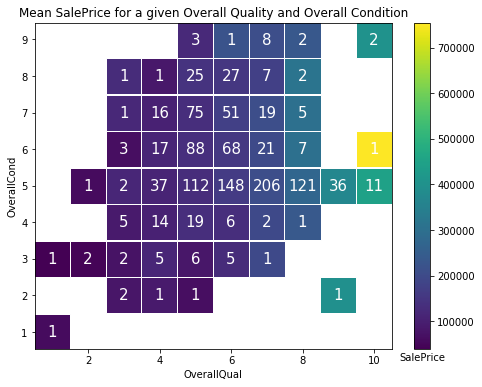

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(ovQual+1, ovCond+1, c=meanSalePrice, s=1300, marker='s', edgecolor='w')
plt.xlabel('OverallQual'),plt.ylabel('OverallCond')
plt.title('Mean SalePrice for a given Overall Quality and Overall Condition')
cbar = plt.colorbar()
cbar.ax.set_xlabel('SalePrice')

for i in range(len(ovQual)):
    plt.text(ovQual[i]+1, ovCond[i]+1, str(nb.values[i]), color="w", fontsize=15, horizontalalignment='center', verticalalignment='center')

plt.show()

The overall quality seems to have a lot more influence than the overall condition. The only one yellow price is not representative because there is only 1 observation to calculate this mean price. It could be considered as an outlier for the feature OverallCond according to the SalePrice... We have to remember its ID, just in case.

In [23]:
pdAllData_Categ.loc[(pdAllData_Categ['OverallQual']==10) & (pdAllData_Categ['OverallCond']==6)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104,21535,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,1,2007,WD,Normal,755000


### 7. Building Type: check the Townhouses

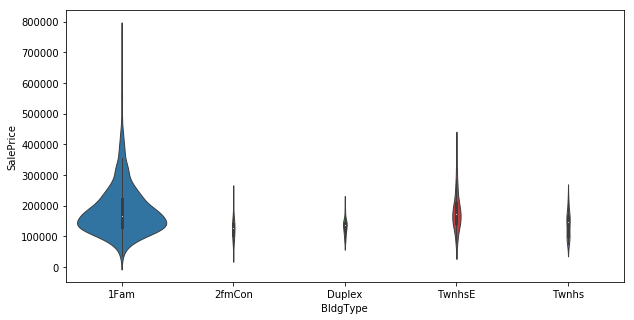

In [24]:
plt.figure(figsize=(10,5))
sns.violinplot("BldgType", "SalePrice", data=pdAllData_Categ, linewidth=1, scale='count')
plt.show()

We had a doubt at the beginning for the Twnhs that hadn't a letter, such as E for End or I for Inside. We note that we don't have any TwnhsI, maybe the Twnhs without letter are the TwnhsI, maybe we don't know. We decide to keep the information like it.
<br>
The 1Fam category has a lot of observations.

### 8. How old is the house?

The age of a house always has an influence on the price, and also the date when it was built, and when it was sold. Do we need to consider a new feature that is the age, or do we already have the good features in the dataset?

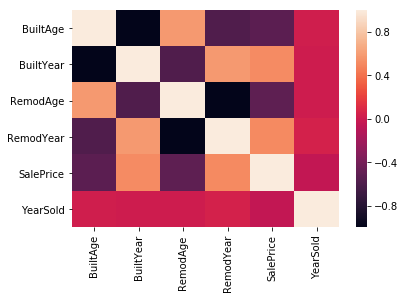

Correlation of features with SalePrice:
 BuiltAge    -0.524754
BuiltYear    0.523194
RemodAge    -0.513059
RemodYear    0.509916
YearSold    -0.039841
Name: SalePrice, dtype: float64


In [25]:
ageData = {
    'BuiltYear': pdAllData_Categ.YearBuilt,
    'RemodYear': pdAllData_Categ.YearRemodAdd,
    'YearSold': pdAllData_Categ.YrSold,
    'BuiltAge': pdAllData_Categ.YrSold - pdAllData_Categ.YearBuilt,
    'RemodAge': pdAllData_Categ.YrSold - pdAllData_Categ.YearRemodAdd,
    'SalePrice': pdAllData_Categ.SalePrice,
}

matCorrAge = pd.DataFrame(ageData).corr()

sns.heatmap(matCorrAge)
plt.show()

print('Correlation of features with SalePrice:\n',matCorrAge.loc['SalePrice'].drop('SalePrice'))

The year when the house is sold has a really low correlation with the SalePrice.
<br>
The year when it was built or remoded has more correlation. We wondered if changing from a year to an age was a good idea or not.
<br>
In the case of the BuiltYear, the gain of correlation is about 0.001. In the case of the Remod Year, the gain of correlation is about 0.003.
<br>
That means we could replace the builtYear by the builtAge, and the RemodYear by the RemodAge to get better results, but we decided that the gain in the correlation was not sufficient to change this.

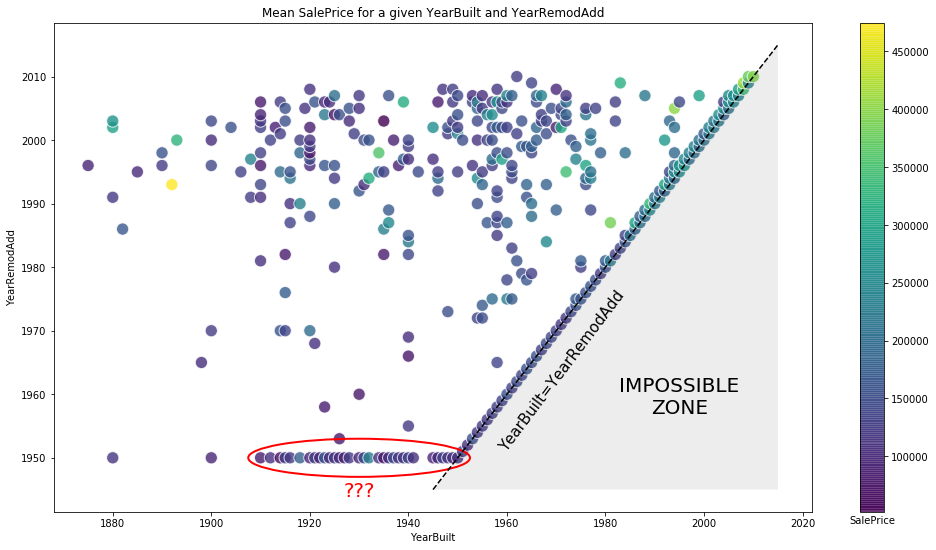

In [26]:
#Retrieve the data

series = pdAllData_Categ.groupby(['YearBuilt', 'YearRemodAdd'])['SalePrice'].mean()
nb = pdAllData_Categ.groupby(['YearBuilt', 'YearRemodAdd']).size()
labels0, labels1 = series.keys().labels[0], series.keys().labels[1]
levels0, levels1 = series.keys().levels[0], series.keys().levels[1]
yB, yR = [levels0[label] for label in labels0], [levels1[label] for label in labels1]
meanSalePrice = series.values

#Plot

plt.figure(figsize=(17,9))

plt.scatter(yB, yR, c=meanSalePrice, s=150, edgecolor='w', alpha=0.8)
plt.xlabel('YearBuilt'),plt.ylabel('YearRemodAdd')
plt.title('Mean SalePrice for a given YearBuilt and YearRemodAdd')
cbar = plt.colorbar()
cbar.ax.set_xlabel('SalePrice')

plt.plot([1945,2015],[1945,2015],'k--')
plt.fill([1945,2015,2015],[1945,2015,1945], 'k', alpha=0.07)
plt.text(1958,1975,'YearBuilt=YearRemodAdd', rotation=53, fontsize=15)
plt.text(1995,1957,'IMPOSSIBLE\nZONE', fontsize=20, horizontalalignment='center')

ax = plt.gca()
ax.add_artist(pat.Ellipse((1930,1950),45,6,color='r',fill=False,lw=2,ls='solid'))
plt.text(1930,1944,'???',horizontalalignment='center',color='r',fontsize=20)

plt.show()

Another thing that could be analysed is the fact that the RemodYear is always after the BuiltYear. Indeed, we can see on the graph that there aren't any observations in the "impossible zone".
<br>
A lot of observations are on the YearBuilt=YearRemodAdd line, that means they haven't been remoded yet (when the house has been sold).
<br>
We have a corridor of approximately '10 years' where very few observations, that means recently built houses are not often remoded.
<br>
The SalePrice is higher for more recent houses. Houses that haven't been remoded within the last 20 years seem to have a lower SalePrice. The house with the higher SalePrice is old, but has been remoded after 1990.
<br><br>
Another thing that can be noted is that a lot of observations seem to have been remoded in 1950 (that also seems to be a limit year because no houses are known to be remoded before this date). The question is: is it the real year of remoding, or maybe when Ames begun to collect the data, they didn't know the information and decided to put 1950...
<br>
The idea to clean this problem in the data could be to align these observations on the YearBuilt=YearRemodAdd line, but actually we don't know... So we decided to do nothing with it.

### 9. LotFrontage: A lot of NA values

We have noted a lot of NA values in the LotFrontage feature that is normally a value encoded with a number. Having NA values in a numerical feature with cause problem with the encoding in the pre-processing. If we don't replace these values, we'll not keep the order because the numerical values have a risk to be encoded with other ones, just as categorized values, but it's not. We must find a way to replace the NA values to keep the ordered information.
<br>
The LotFrontage is said to be the "Linear feet of street connected to property".

In [27]:
print(pdAllData_Categ.LotFrontage.loc[pdAllData_Categ.LotFrontage == str(0)])

Series([], Name: LotFrontage, dtype: object)


There is no observation with a LotFrontage equal to 0. Maybe NA could mean that there is no lotFrontage, and could replace a 0 value...?
<br>
We decided to replace the NA values by 0 values.

In [28]:
def cleanLotFrontage(data):
    #Replace the NA values by 0 values and transform the type to int64
    cleaned_data = data.replace({'LotFrontage':{'NA': '0'}}).astype({'LotFrontage':'int64'})
    return cleaned_data

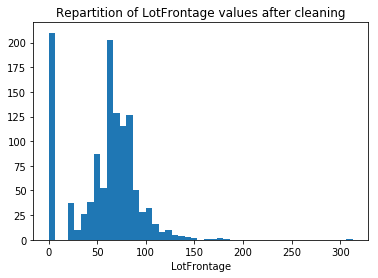

In [29]:
cleaned_lotFrontage_data = cleanLotFrontage(pdAllData_Categ)

plt.hist(cleaned_lotFrontage_data.LotFrontage, bins='auto')
plt.xlabel('LotFrontage')
plt.title('Repartition of LotFrontage values after cleaning')
plt.show()

It could maybe not be really realistic to have so many observations to 0, but to keep the rest of the information, we need to fill it.
<br>
Another solution could be to loose the approcimately 200 observations... that means 1/6 of the dataset! Or maybe we could delete this feature...

### 10. GarageYrBlt: NA values to fill?

With this feature we have the same problem as before with the LotFrontage.

In [30]:
print('When GarageYrBlt = NA, GarageType has values',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.GarageYrBlt=='NA',axis=1)].GarageType.values))

When GarageYrBlt = NA, GarageType has values {'NA'}


The value 'NA' in the GarageType feature clearly means that there is no garage for this house. A good solution could be to set the 67 NA values for the GarageYrBlt to the year the house was built, because it's often the case, and even if there is no garage, it doesn't give any penalty or bonus to these houses. It's a quite good way to replace these NA values.

In [31]:
def cleanGarageYrBlt(data):
    #Replace the NA values by the year when the house was built and transform the type to float64
    cleaned_data = data.replace({'GarageYrBlt':{'NA': '0'}}).astype({'GarageYrBlt':'float64'}) #replace by zero first to change the type
    cleaned_data_serie = cleaned_data.GarageYrBlt.mask(cleaned_data.GarageYrBlt == 0, cleaned_data.YearBuilt)
    cleaned_data['GarageYrBlt'] = cleaned_data_serie #replace by the value YearBuilt
    return cleaned_data

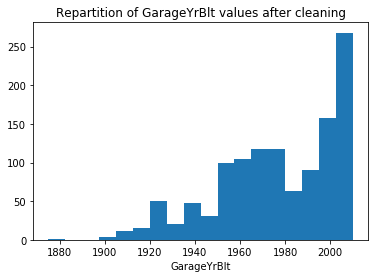

In [32]:
cleaned_GarageYrBlt_data = cleanGarageYrBlt(pdAllData_Categ)


plt.hist(cleaned_GarageYrBlt_data.GarageYrBlt, bins='auto')
plt.xlabel('GarageYrBlt')
plt.title('Repartition of GarageYrBlt values after cleaning')
plt.show()

### 11. MasVnrArea and MasVnrType: NA values

MasVnrType is said to have some NA values, such as MasVnrArea has.
<br>
In the description file, MasVnrArea is said to be "Masonry veneer type", it's a categorised feature, whereas MasVnrArea is a numerical one, and can raise issues as the previous NA values in numerical columns.
<br>
First, let's try to understand the NA values.

In [33]:
print('When MasVnrArea = NA, MasVnrType has values',set(pdAllData_Categ[pdAllData_Categ.apply(lambda x: x.MasVnrArea=='NA',axis=1)].MasVnrType.values))

When MasVnrArea = NA, MasVnrType has values {'NA'}


The NA are exactly for the same rows, because we have the same number of NA values for each feature, and when MasVnrArea is NA, MasVnrType is always NA.

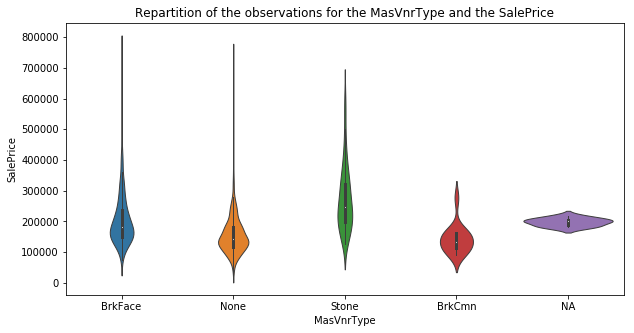

In [34]:
plt.figure(figsize=(10,5))
sns.violinplot("MasVnrType", "SalePrice", data=pdAllData_Categ, linewidth=1)
plt.title('Repartition of the observations for the MasVnrType and the SalePrice')
plt.show()

We already have the possibility of 'None'. NA values could be None values with errors when typing, or are a 'non available' information.
<br>
We can decide to keep the MasVnrType like it, but for the Area, it's again the problem of a NA value in a numerical column.

In [35]:
#Replace MasVnrArea NA values by 0 and change the dtype to be able to calculate the mean by category in the next line
intermediate_NAcleaning_MasVnrArea = pdAllData_Categ.replace({'MasVnrArea':{'NA': '0'}}).astype({'MasVnrArea':'int64'})
#calculate the mean of Area of the other observations
print('Mean of Area of all the other observations =',(pdAllData_Categ.MasVnrType.value_counts() * intermediate_NAcleaning_MasVnrArea.groupby('MasVnrType')['MasVnrArea'].mean()).sum()/(pdAllData_Categ.MasVnrType.value_counts().sum()-6))

Mean of Area of all the other observations = 103.96231155778895


The idea, as we don't know what does that means, is to replace it with the mean of the other observations, that is approximately 104. There are only 6 observations that needs to be cleaned with this method, so the impact of our transformation will be minimal.

In [36]:
def cleanMasVnrArea(data):
    #Replace the NA values by the mean of other observations and transform the type to int64
    cleaned_data = data.replace({'MasVnrArea':{'NA': '104'}}).astype({'MasVnrArea':'int64'})
    return cleaned_data

## C. Data cleaning: change in the dataframe values

We have already written some functions to clean some features of the data that needed to be cleaned. Now, we'll write a cleaning function that groups the cleaning sub-functions with the possibility to choose the cleaning to perform or not.

In [37]:
#define a function that will process the 3 cleaning function previously written
def cleaning(data, LotFrontage=True, GarageYrBlt=True, MasVnrArea=True):
    if LotFrontage: data = cleanLotFrontage(data)
    if GarageYrBlt: data = cleanGarageYrBlt(data)
    if MasVnrArea: data = cleanMasVnrArea(data)
    return data

## D. The random lognormal model: a naive model

As it was said in the previous part (data statistics about the data), the distribution of SalePrice is lognormal, that means the log of the salePrice is normal. Without using any feature, we can try to implement a very simple random model that will simply generate salePrice samples thanks to the lognormal distribution found in the training set.
<br>
It's a good start to implement the error function to calculate the logRMSE and get an idea of the result.

### 1. Getting familiar with the error

In [38]:
def getLogRMSE(estimatedPrice,realPrice):
    logRMSE = np.mean( (np.log(estimatedPrice) - np.log(realPrice))**2 )
    return np.sqrt(logRMSE)

In [39]:
def getAccuracyPercents(estimatedPrice,realPrice):
    return 100 - np.mean(np.abs(estimatedPrice-realPrice)/realPrice) * 100

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


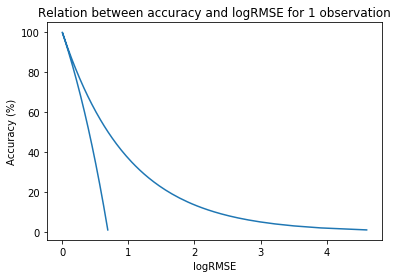

In [47]:
realPrice = 100
estimatedPrices = range(0,200)
logRMSEsVisualise = [getLogRMSE(np.array([estimatedPrice]),np.array([realPrice])) for estimatedPrice in estimatedPrices]
accuracyPercentsVisualise = [getAccuracyPercents(np.array([estimatedPrice]),np.array([realPrice])) for estimatedPrice in estimatedPrices]

#Plot
plt.plot(logRMSEsVisualise, accuracyPercentsVisualise, '-')
plt.xlabel('logRMSE'), plt.ylabel('Accuracy (%)')
plt.title('Relation between accuracy and logRMSE for 1 observation')
plt.show()

EXPLAIN WHY THE ERROR IS USED

### 2. Implement the random lognormal model

In [41]:
logRMSEsRand = []
accuracies = []

for i in range(5000):
    #get validation and train data randomly
    pdTrainData, pdValidationData = train_test_split(pdAllData_Categ, test_size=0.1)

    #Get the mean and the standard deviation
    meanLogSalePrice = np.log(pdTrainData.SalePrice).mean()
    stdLogSalePrice = np.log(pdTrainData.SalePrice).std()

    #Generate the log of prices randomly with a gaussian approximation
    randomLogSalePrices = np.random.normal(meanLogSalePrice, stdLogSalePrice, len(pdValidationData))
    randomSalePrices = np.exp(randomLogSalePrices)
    pdRandomSalePrices = pd.Series(randomSalePrices)

    #retrieve the error logRMSE and the accuracy
    logRMSEsRand.append(getLogRMSE(pdRandomSalePrices, pdValidationData.SalePrice))
    accuracies.append(getAccuracyPercents(pdRandomSalePrices, pdValidationData.SalePrice))
    
print("Mean of LogRMSEs of a totally random model:", np.mean(logRMSEsRand))
print("Mean of accuracies in % of a totally random model:", np.mean(accuracies), '%')

Mean of LogRMSEs of a totally random model: 0.5499700173560934
Mean of accuracies in % of a totally random model: 48.86232218409152 %


## E. Label encoding

The data may be clean, it contains unconsistent datatype; strings, int and float. However, as mentioned before, we decided to use a tree model to solve this problem and tree models give better results on datasets with numerical features. Therefore the first step of our pipeline is to transform string values to numbers which is encode categorical features.
<br>
Encoding categorical features consists in transforming discrete string values to numerical values . To do so, many techniques exists, we decided to study 3 approaches: automatic label encoding, automatic one hot encoding, and a homemade ordered label encoding.
<br><br>
Label encoding consists in simply associating to a string value of a categorical feature a new int value. For example, the Alley feature has possible values Grvl, Pave and NA. A possible encoding would replace all Grvl values by 0, Pave values by 1 and NA values by 2. The main disadvantage of this simple technique is that it introduces an order between the numerical values that can lead to missinterpretation of this feature by the model.
<br>
In order to fix this problem, we also have coded a homemade label encoder that tries to have a good order. The order is based on the median SalePrice of each Category. Consequently, we'll try to maximize the correlation between the encoded categorical feature and the SalePrice.
<br>
The one-hot encoding tries also to cope with order problem by introducing dummy variables. In short, for each possible values, we introduce a new column with binary values for each possible category for a given feature. We split one column into nb_categories binary columns. In the case of the alley, we would add three column Alley_Pave, Alley_Grvl and Alley_NA. If a house has no alley, then we would have 0 in Alley_Pave and Alley_Grvl and a 1 in the Alley-NA column. In the special case where the feature has only two possible values, there is no need to add a column, we simply choose one value to be 0 and the other to be 1.

In [53]:
def labelEncoder(Data):
    
    """Automatic label encoder for all columns that need to be encoded."""
    
    data_frames = [] #Gather encoded series to concatenate at the end   
    lb_make = LabelEncoder() #Sklearn automatic encoder
    
    for featureCol in Data : #for each column
        
        if Data[featureCol].dtype=='object': #Categorical Feature if dtype object (there is at least one str type in the column)
            encode_col = pd.Series(lb_make.fit_transform(Data[featureCol])) #encode with fit_transform
            encode_col.name = featureCol
            data_frames.append(encode_col)
            
        else:
            data_frames.append(Data[featureCol]) #only append the same column, no encoding
    
    return data_frames

In [54]:
def labelEncodingOrdered(column,columnTest,SalePrice):
    
    """Homemade label encoder with order for 1 column."""
    
    #Retrieve a dataframe which is the column and the salePrice
    colANDprice = pd.DataFrame({str(column.name): column, 'SalePrice': SalePrice})
    #Retrieve the median value of SalePrice for each possible value in the column, and sort by median salePrice value
    valueDF = colANDprice.groupby(str(column.name))['SalePrice'].median().reset_index(name='median').sort_values('median').values
    
    #construct the dictionary to know how to replace values
    dictio = {}
    for i,valueList in enumerate(valueDF):
        dictio[valueList[0]] = i
    
    #How to replace the test unknown values that are not in train?
    #Solution: Give the mean value of the other new possible encoded values to reduce the impact of an unknown value
    #Problem: Can lose the information of a new Category by giving the same number as a previously known category
    #         And give the same new value for all the unknown categories
    #         Not really a problem because we don't known anything on these categories
    notInTrainValues_score = np.mean(list(dictio.values())) #get the new value for unknown categories
    def replaceByScore(val): 
        if val not in dictio: dictio[val] = notInTrainValues_score
    notInTrainValues = columnTest.apply(replaceByScore)
    
    return column.replace(dictio), columnTest.replace(dictio), dictio

def labelEncoderOrderedWTestData(Data,DataTest):
    
    """Do the homemade label encoder for all columns (uses the labelEncodingOrdered function to encode each column) that need to be encoded."""
    
    #Gather encoded series to concatenate at the end
    data_frames = []
    data_frames_test = []
    
    for featureCol in Data: #for each column
        
        if Data[featureCol].dtype=='object': #Categorical Features same condition as the automatic label encoder
            new_col, new_col_test, dictio = labelEncodingOrdered(Data[featureCol],DataTest[featureCol],Data.SalePrice)
            data_frames.append(new_col)
            data_frames_test.append(new_col_test)
            
        else: #numerical feature, do not encode, just keep it
            data_frames.append(Data[featureCol])
            if featureCol != 'SalePrice': #do not consider the SalePrice column for the test data
                data_frames_test.append(DataTest[featureCol])
    
    return data_frames, data_frames_test

In [55]:
def oneHotEncoder(Data):
    
    """Automatic one hot encoder for all columns that need to be encoded."""
    
    data_frames = [] #Gather encoded series to concatenate at the end
    
    for featureCol in Data: #for each column
        if Data[featureCol].dtype=='object':
            
            lb_style = LabelBinarizer()
            lb_results = lb_style.fit_transform(Data[featureCol])
            
            if(len(lb_style.classes_)==2):
                columnsNames = [featureCol] # Simple binarisation -> one column resulting from two classes 
            else:
                columnsNames = lb_style.classes_ # One column for each possible values 

            lb_results = pd.DataFrame(lb_results, columns=[featureCol+"_"+name for name in columnsNames]) #create dataframe
            data_frames.append(lb_results)
            
        else: #just keep the column like it
            data_frames.append(Data[featureCol])
    
    return data_frames

In [95]:
def encodeCategoricalFeatures(Data, DataTest=[], encoding_technique='labelEncode'):
    
    """
    Encode the input dataframe Data using the label or one hot encoding technique
    Choose a label encoding: 'labelEncode', 'persoLabelEncodeOrdered' or 'oneHotEncode'.
    """
    
    #Gather encoded series to concatenate at the end
    data_frames = []
    data_frames_test = []
    
    #default value to pdTestData
    pdTestData = None
    
    if encoding_technique == 'labelEncode': #Label Encoding technique
        data_frames = labelEncoder(Data)
                
    elif encoding_technique == 'persoLabelEncodeOrdered': #hommade label encoding ordered
        data_frames, data_frames_test = labelEncoderOrderedWTestData(Data, DataTest) #encode test data only with this method (best results)
        pdTestData = pd.concat(data_frames_test, axis=1) #concat test data only with this encoding technique
                    
    elif encoding_technique == 'oneHotEncode': #one hot label encoding
        data_frames = oneHotEncoder(Data)
                
    else: raise Exception("Choose an encoding technique among 'labelEncode' 'persoLabelEncodeOrdered' 'oneHotEncode'")
    
    pdAllData = pd.concat(data_frames,axis=1) #concat pdAllData
    
    return pdAllData, pdTestData

In [57]:
#Result of labelEncode method
pdAllData_Categ_clean = cleaning(pdAllData_Categ) #clean train data
pdAllData_labelEncode,_ = encodeCategoricalFeatures(pdAllData_Categ_clean,encoding_technique='labelEncode')
pdAllData_labelEncode.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65,8450,1,1,3,3,0,...,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,80,9600,1,1,3,3,0,...,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,68,11250,1,1,0,3,0,...,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,60,9550,1,1,0,3,0,...,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,84,14260,1,1,0,3,0,...,0,3,4,1,0,12,2008,8,4,250000


In [58]:
#Result of homemade label encode ordered method
pdAllData_Categ_clean = cleaning(pdAllData_Categ) #clean train data
pdTestData_Categ_clean = cleaning(pdTestData_Categ) #clean test data
pdAllData,pdTestData = encodeCategoricalFeatures(pdAllData_Categ_clean,pdTestData_Categ_clean,encoding_technique='persoLabelEncodeOrdered')
pdAllData.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65,8450,1,1,0,1,1,...,0,0,4,3,0,2,2008,5,4,208500
1,2,20,3,80,9600,1,1,0,1,1,...,0,0,4,3,0,5,2007,5,4,181500
2,3,60,3,68,11250,1,1,1,1,1,...,0,0,4,3,0,9,2008,5,4,223500
3,4,70,3,60,9550,1,1,1,1,1,...,0,0,4,3,0,2,2006,5,1,140000
4,5,60,3,84,14260,1,1,1,1,1,...,0,0,4,3,0,12,2008,5,4,250000


In [59]:
#Result of one hot encode method
pdAllData_Categ_clean = cleaning(pdAllData_Categ) #clean train data
pdAllData_oneHot,_ = encodeCategoricalFeatures(pdAllData_Categ,encoding_technique='oneHotEncode')
pdAllData_oneHot.head()

,Id,MSSubClass,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotFrontage_100,LotFrontage_101,LotFrontage_102,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,208500
1,2,20,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,181500
2,3,60,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,223500
3,4,70,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,140000
4,5,60,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,250000


## F. Pre-processing pipeling

### 1. Implement the preprocessing and process the data

In [96]:
def preprocessing(pdAllData_Categ, pdTestData_Categ=[], scaling=True, encoding_technique='labelEncode'):
    
    #Cleaning
    pdAllData_Categ_clean = cleaning(pdAllData_Categ) #clean the train data
    pdTestData_Categ_clean = cleaning(pdTestData_Categ) #clean the test data
    
    #Labels Encoding
    pdAllData, pdTestData = encodeCategoricalFeatures(pdAllData_Categ_clean, pdTestData_Categ_clean, encoding_technique)
    
    #Retriev X and Y by droping some columns
    X = pdAllData.drop(['Id','SalePrice'],axis=1)
    
    kept_columnValues = list(X.columns.values) #names of the columns not dropped of X
    
    if encoding_technique == 'persoLabelEncodeOrdered': #Encode the same way test data
        X_test = pdTestData.drop(['Id'], axis=1) #Drop the ID of the test only with this encoding method
        allX = pd.concat([X,X_test], axis=0) #Ensure same scaling between test and training by grouping the data and apply one time the function
        
        if scaling:
            #Scaling to have better results
            X_scaled_array = StandardScaler().fit_transform(allX)
            X_scaled = pd.DataFrame(X_scaled_array, columns=kept_columnValues)
        else: X_scaled = allX
        
        return X_scaled.iloc[range(1200)], X_scaled.iloc[range(1200,len(allX))] #return the train and test data
    
    else: #for other encoding techniques, no need to encode the test data
        if scaling:
            #Scaling to have better results
            X_scaled_array = StandardScaler().fit_transform(X)
            X_scaled = pd.DataFrame(X_scaled_array, columns=kept_columnValues)
        else: X_scaled = X
        
        return X_scaled, []

In [101]:
#Preprocess the data with different encoders
#Clean, encode, scale

X_scaled_labelEncode, _ = preprocessing(pdAllData_Categ, pdTestData_Categ, encoding_technique='labelEncode')
X_scaled_OneHotEncode, _ = preprocessing(pdAllData_Categ, pdTestData_Categ, encoding_technique='oneHotEncode')
X_scaled_labelEncodeOrdered, X_scaled_test = preprocessing(pdAllData_Categ, pdTestData_Categ, encoding_technique='persoLabelEncodeOrdered')

Y = pdAllData_Categ.SalePrice

X_scaled_labelEncode_WPrice = pd.concat([X_scaled_labelEncode,Y],axis=1)
X_scaled_OneHotEncode_WPrice = pd.concat([X_scaled_OneHotEncode,Y],axis=1)
X_scaled_labelEncodeOrdered_WPrice = pd.concat([X_scaled_labelEncodeOrdered,Y],axis=1)

### 2. Overview of the preprocessed data

Now the data has been preprocessed, it's clean enough to have a good overview of the features and their correlation.
<br>
Note that on the plots, all the features are plotted, even if we don't see all their names.

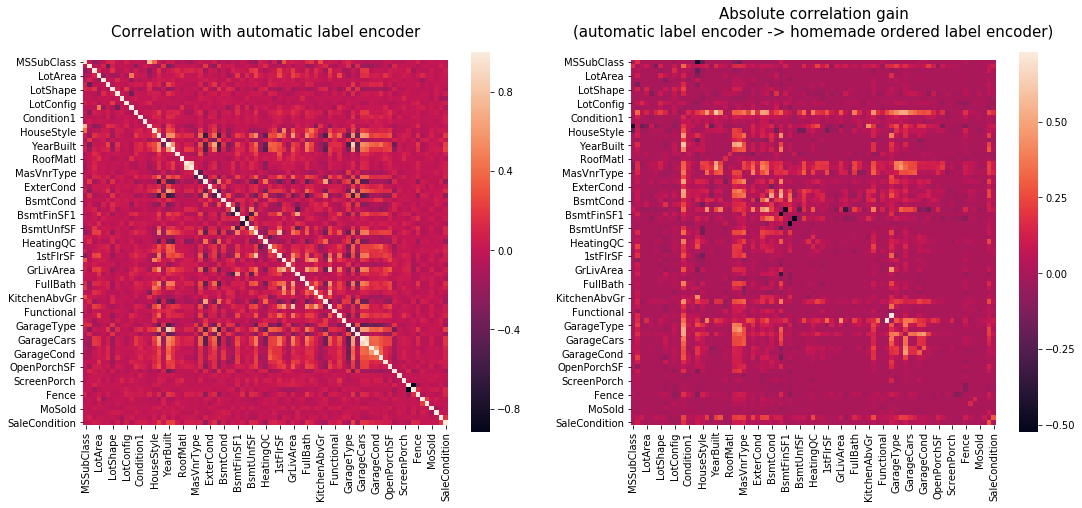

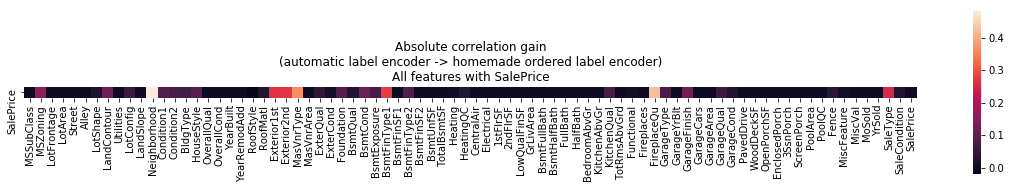

In [100]:
#Plot1

plt.figure(figsize=(18,7))

plt.subplot(121)
sns.heatmap(X_scaled_labelEncode.corr(), square=True)
plt.title('Correlation with automatic label encoder\n', fontsize=15)

plt.subplot(122)
sns.heatmap(np.abs(X_scaled_labelEncodeOrdered.corr()) - np.abs(X_scaled_labelEncode.corr()), square=True)
plt.title('Absolute correlation gain\n(automatic label encoder -> homemade ordered label encoder)\n', fontsize=15)

plt.show()

#Plot2

plt.figure(figsize=(20,3))

gain = pd.DataFrame(np.abs(X_scaled_labelEncodeOrdered_WPrice.corr()['SalePrice']) - np.abs(X_scaled_labelEncode_WPrice.corr()['SalePrice']),columns=['SalePrice'])
sns.heatmap(gain.T, square=True)
plt.title('Absolute correlation gain\n(automatic label encoder -> homemade ordered label encoder)\nAll features with SalePrice')

plt.show()

The left matrix shows us the correlation between the different encoded features. The left matrix represents the evolution in the absolute correlation changing from the automatic label encoder to the homade ordered one.
<br>
We see that in major cases there is no really change, but there are more positive changes that improve the absolute correlation than negative changes. What is important is the correlation with the SalePrice variable that will help to find the good values.
<br>
The gain is not often negative, we have increased the correlation with SalePrice with our encoding in major case. Seven features have seen their correlation with SalePrice increasing by at least 0.2. It's a quite good result.
<br><br>
We'll not see the matrix with the one hot encoding because they are too many features, it's unreadable!

## G. Outliers Detection

Because we know that some observations are not really like the others and could be a problem for us to give a good SalePrice, it could be better to spot the outliers.
<br>
The question is: how to determine an observation as an outlier?
<br>
There are several possibilities to detect outliers. As we'll do trees and forests to find the SalePrice, we decided to use a isolationForest method to detect the outliers.

In [109]:
def findOutliers_IsolationForest(outlierDetectionData, X, Y, outliers_fraction):
    
    """Detect outliers thanks to an isolation forest method and return data with outliers removed, the threshold used..."""
    
    #Define the classifier IsolationForest and train it
    clf = IsolationForest(max_samples=len(outlierDetectionData), contamination=outliers_fraction, random_state=42)
    clf.fit(outlierDetectionData)
    
    #Retrieve the predicted scores (a low score indicates that it could be an outlier)
    scores_pred = clf.decision_function(outlierDetectionData)
    #Retrieve the status of each observation as a list of 1 or -1
    y_pred = clf.predict(outlierDetectionData) # 1 is predicted to be a normal observation, -1 is considered an outlier
    #Retrieve the outliers index
    outliers_index = np.where(y_pred==-1)[0]
    
    X_inlier, Y_inlier = X.drop(outliers_index,axis=0), Y.drop(outliers_index,axis=0) #remove outliers in X and Y
    X_outlier, Y_outlier = X.filter(outliers_index,axis=0), Y.filter(outliers_index,axis=0) #keep outliers data just in case it's needed
    
    #Retrieve the score threshold to determine the status of observations (outlier/inlier)
    threshold = scipy.stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
    
    return scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier

In [118]:
#Plot function
def plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier):

    plt.figure(figsize=(16,10))
    
    #First plot
    plt.subplot(321)
    scores_pred_sorted = np.sort(scores_pred)
    plt.plot([0,1199],[threshold]*2,'--',c='red')
    plt.plot(scores_pred_sorted)
    plt.xlabel("sample"),plt.ylabel("score")
    plt.title('Sorted scores of observations')
    
    #Second plot
    plt.subplot(322)
    plt.hist(scores_pred_sorted, bins='auto')
    plt.xlabel("score"),plt.ylabel("nb of samples")
    plt.title('Repartition of the score')
    
    #Third plot
    ax = plt.subplot(3,1,(2,3))
    #Retrieve inliers and outliers and scatter
    inlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==1])
    outlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==-1])
    plt.scatter(Y_inlier, inlier.T[1], marker="o", c=colors.filter(inlier.T[0]), cmap=cmap, label="Inliers")
    plt.scatter(Y_outlier, outlier.T[1], marker="^", c=colors.filter(outlier.T[0]), cmap=cmap, label="Outliers")
    plt.xlabel('SalePrice')
    plt.ylabel('Outlier Score')
    #write the ids of outliers next to them
    for i in range(len(Y_outlier)):
        ax.annotate(Y_outlier.iloc[[i]].keys()[0], (Y_outlier.iloc[[i]].values[0],outlier.T[1][i]))
    plt.plot([0,750000],[threshold]*2,'--',c='red') #plot the threshold limit
    plt.legend()
    
    plt.show()

In order to understand better how the outliers are defined, we'll try to detect outliers thanks to SalePrice only. Normally outliers should be observations with really low or really high SalePrice, and must represent 5% of the data.

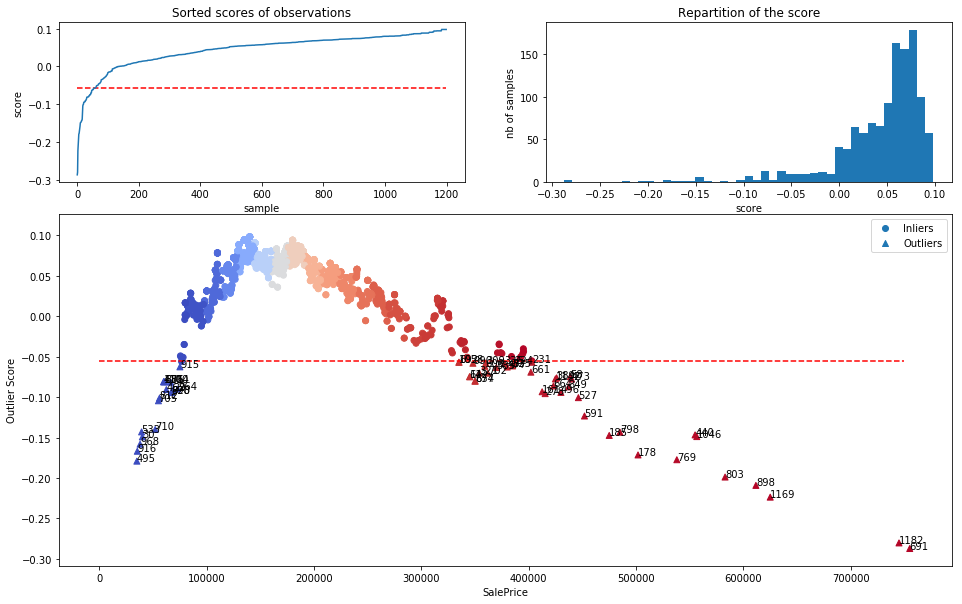

In [119]:
outliers_fraction = 0.05

X = X_scaled_labelEncodeOrdered
scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier = findOutliers_IsolationForest(Y.values.reshape(-1,1), X, Y, outliers_fraction)
plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier)

The outliers are chosen as expected: with high or low prices.
<br>
The next step is now to take into account all the features and the SalePrice to detect the outliers. We'll use the encoded dataset with the order label encoder.

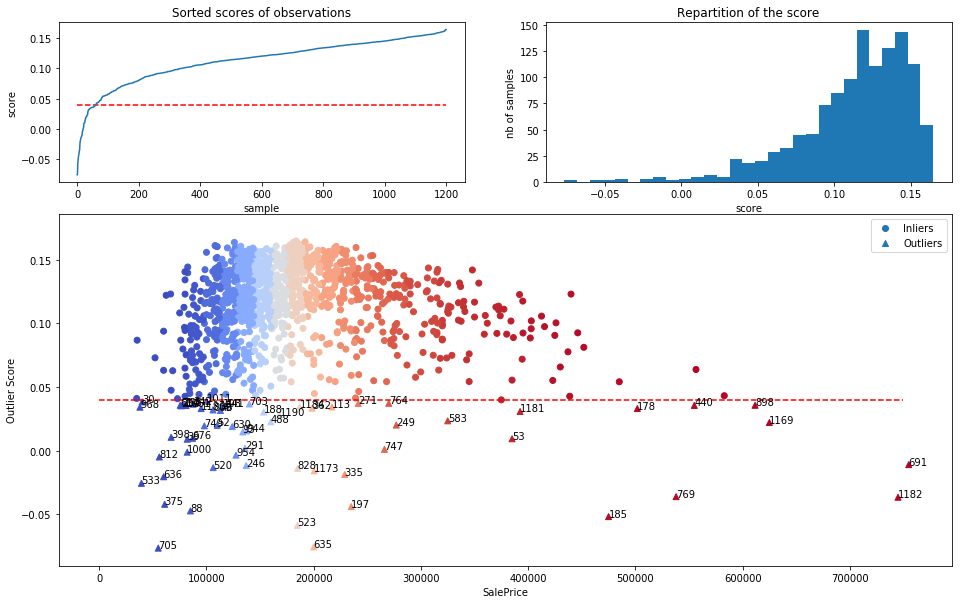

In [120]:
scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier = findOutliers_IsolationForest(X_scaled_labelEncodeOrdered_WPrice, X_scaled_labelEncodeOrdered, Y, outliers_fraction)
plotOutliers(scores_pred, y_pred, threshold, X_inlier, Y_inlier, X_outlier, Y_outlier)

Outliers are not observations with only low or high sale price anymore.
<br>
The outlier detected during the data statistics (id=691) is considered as an outlier in both cases.
<br>
We can see that outliers are of every salePrice. The repartition of outliers seems to represent the repartition of SalePrice in the data.

The question is now: what to do with outliers?

COMMENT TO ADD